## **import**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN

import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'

In [3]:
train = pd.read_csv("../Database/train.csv")
test = pd.read_csv("../Database/submission.csv")
test.drop('id' , axis = 1 , inplace = True)

In [4]:
# 사용하지 않을 column 제외
train.drop('customer_country.1',axis = 1 , inplace = True)
train.drop('product_modelname',axis = 1 , inplace = True)

test.drop('customer_country.1',axis = 1 , inplace = True)
test.drop('product_modelname',axis = 1 , inplace = True)

# 모든 문자 소문자로
for column in train.columns:
    if train[column].dtype == 'object':  # 문자열을 포함하는 컬럼 타입인지 확인
        train[column] = train[column].str.lower()

for column in test.columns:
    if test[column].dtype == 'object':  # 문자열을 포함하는 컬럼 타입인지 확인
        test[column] = test[column].str.lower()

In [24]:
# other 문자열 존재 여부
contains_other = train['inquiry_type'].str.contains('other', case=False, na=False)
print("Number of True values:", contains_other.sum())

Number of True values: 1180


In [25]:
none_col = ['customer_country','customer_type','customer_job','product_category','product_subcategory','business_area','business_subarea','expected_timeline','inquiry_type']
zero_col = ['com_reg_ver_win_rate','historical_existing_cnt','id_strategic_ver','it_strategic_ver','idit_strategic_ver','ver_win_rate_x','ver_win_ratio_per_bu']
# other_col = ['']

In [26]:
for col in none_col:
    train[col] = train[col].fillna('none')
    test[col] = test[col].fillna('none')

# 0으로 대체할 컬럼에 대해 결측치를 대체합니다.
for col in zero_col:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

# for col in other_col:
#     train[col] = train[col].fillna('other')
#     test[col] = test[col].fillna('other')

train.loc[train['customer_country'] == 'none', 'customer_country'] = '//none'
test.loc[test['customer_country'] == 'none', 'customer_country'] = '//none'

In [13]:
obj_col = ['customer_idx', 'customer_type','customer_job', 'inquiry_type','product_category','product_subcategory','product_modelname', 'customer_position','response_corporate','expected_timeline','business_subarea']

In [14]:
# 'customer_idx'의 각 값에 대한 빈도수 계산
frequency = train['customer_idx'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['customer_idx'] = train['customer_idx'].replace(idx_to_replace, -1)



train.loc[train['customer_type'] == 'end customer', 'customer_type'] = 'end-customer'
train.loc[train['customer_type'] == 'specifier / influencer', 'customer_type'] = 'specifier/ influencer'
# 'customer_type'의 각 값에 대한 빈도수 계산
frequency = train['customer_type'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['customer_type'] = train['customer_type'].replace(idx_to_replace, 'other')



# 'customer_type'의 각 값에 대한 빈도수 계산
frequency = train['customer_job'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['customer_job'] = train['customer_job'].replace(idx_to_replace, 'other')


train.loc[train['inquiry_type'] == 'etc.', 'inquiry_type'] = 'other'
train.loc[train['inquiry_type'] == 'other_', 'inquiry_type'] = 'other'
train.loc[train['inquiry_type'] == 'others', 'inquiry_type'] = 'other'
frequency = train['inquiry_type'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['inquiry_type'] = train['inquiry_type'].replace(idx_to_replace, 'other')




train.loc[train['product_category'] == 'etc.', 'product_category'] = 'other'
frequency = train['product_category'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['product_category'] = train['product_category'].replace(idx_to_replace, 'other')




frequency = train['product_subcategory'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['product_subcategory'] = train['product_subcategory'].replace(idx_to_replace, 'other')




train.loc[train['customer_position'] == 'others', 'customer_position'] = 'other'
frequency = train['customer_position'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['customer_position'] = train['customer_position'].replace(idx_to_replace, 'other')




frequency = train['response_corporate'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['response_corporate'] = train['response_corporate'].replace(idx_to_replace, 'other')




train.loc[train['expected_timeline'] == 'less_than_3_month.', 'expected_timeline'] = 'less than 3 month'
train.loc[train['expected_timeline'] == '3_month_~_6_month', 'expected_timeline'] = '3 month ~ 6 month'
train.loc[train['expected_timeline'] == '6_month_~_9_month', 'expected_timeline'] = '6 month ~ 9 month'
frequency = train['expected_timeline'].value_counts()
idx_to_replace = frequency[frequency <= 21].index
train['expected_timeline'] = train['expected_timeline'].replace(idx_to_replace, 'other')



train.loc[train['business_subarea'] == 'others', 'business_subarea'] = 'other'
frequency = train['business_subarea'].value_counts()
idx_to_replace = frequency[frequency <= 10].index
train['business_subarea'] = train['expected_timeline'].replace(idx_to_replace, 'other')

In [15]:
train_unique_values = {
    'customer_idx': set(train[train['customer_idx'] != 'other' ]['customer_idx']),
    'customer_type': set(train[train['customer_type'] != 'other']['customer_type']),
    'customer_job': set(train[train['customer_job'] != 'other']['customer_job']),
    'inquiry_type': set(train[train['inquiry_type'] != 'other']['inquiry_type']),
    'product_category': set(train[train['product_category'] != 'other']['product_category']),
    'product_subcategory': set(train[train['product_subcategory'] != 'other']['product_subcategory']),
    'customer_position': set(train[train['customer_position'] != 'other']['customer_position']),
    'response_corporate': set(train[train['response_corporate'] != 'other']['response_corporate']),
    'expected_timeline': set(train[train['expected_timeline'] != 'other']['expected_timeline']),
    'business_subarea': set(train[train['business_subarea'] != 'other']['business_subarea'])
}

# test 데이터셋에 대한 전처리를 수행합니다.
# 먼저, 'other'로 치환될 값들을 정의합니다.
test_replacements = {
    'customer_type': {
        'end customer': 'end-customer',
        'specifier / influencer': 'specifier/ influencer'
    },
    'inquiry_type': {
        'etc.': 'other',
        'other_': 'other',
        'others': 'other'
    },
    'product_category': {
        'etc.': 'other'
    },
    'customer_position': {
        'others': 'other'
    },
    'expected_timeline': {
        'less_than_3_month.': 'less than 3 month',
        '3_month_~_6_month': '3 month ~ 6 month',
        '6_month_~_9_month': '6 month ~ 9 month'
    },
    'business_subarea': {
        'others': 'other'
    }
}

# test 데이터셋의 컬럼들에 대해 'other'로 치환할 필요가 있는 값을 치환합니다.
for col, replacements in test_replacements.items():
    test[col].replace(replacements, inplace=True)

# 이제, train 데이터셋에서 'other'로 레이블된 값을 기반으로
# test 데이터셋에서 해당하지 않는 값들을 'other'로 치환합니다.
for col, unique_values in train_unique_values.items():
    test[col] = test[col].apply(lambda x: x if x in unique_values else 'unknown')

In [16]:
for i in train.columns:
    print(f'{i} 컬럼의 고유값 개수: {train[i].nunique()}')

bant_submit 컬럼의 고유값 개수: 5
customer_country 컬럼의 고유값 개수: 13712
business_unit 컬럼의 고유값 개수: 5
com_reg_ver_win_rate 컬럼의 고유값 개수: 81
customer_idx 컬럼의 고유값 개수: 100
customer_type 컬럼의 고유값 개수: 14
enterprise 컬럼의 고유값 개수: 2
historical_existing_cnt 컬럼의 고유값 개수: 136
id_strategic_ver 컬럼의 고유값 개수: 2
it_strategic_ver 컬럼의 고유값 개수: 2
idit_strategic_ver 컬럼의 고유값 개수: 2
customer_job 컬럼의 고유값 개수: 61
lead_desc_length 컬럼의 고유값 개수: 909
inquiry_type 컬럼의 고유값 개수: 17
product_category 컬럼의 고유값 개수: 74
product_subcategory 컬럼의 고유값 개수: 127
customer_position 컬럼의 고유값 개수: 26
response_corporate 컬럼의 고유값 개수: 47
expected_timeline 컬럼의 고유값 개수: 12
ver_cus 컬럼의 고유값 개수: 2
ver_pro 컬럼의 고유값 개수: 2
ver_win_rate_x 컬럼의 고유값 개수: 13
ver_win_ratio_per_bu 컬럼의 고유값 개수: 24
business_area 컬럼의 고유값 개수: 13
business_subarea 컬럼의 고유값 개수: 12
lead_owner 컬럼의 고유값 개수: 984
is_converted 컬럼의 고유값 개수: 2


In [17]:
for i in train.columns:
    print(f'{i} 컬럼의 고유값 개수: {test[i].nunique()}')

bant_submit 컬럼의 고유값 개수: 5
customer_country 컬럼의 고유값 개수: 2292
business_unit 컬럼의 고유값 개수: 3
com_reg_ver_win_rate 컬럼의 고유값 개수: 78
customer_idx 컬럼의 고유값 개수: 42
customer_type 컬럼의 고유값 개수: 7
enterprise 컬럼의 고유값 개수: 2
historical_existing_cnt 컬럼의 고유값 개수: 74
id_strategic_ver 컬럼의 고유값 개수: 2
it_strategic_ver 컬럼의 고유값 개수: 2
idit_strategic_ver 컬럼의 고유값 개수: 2
customer_job 컬럼의 고유값 개수: 38
lead_desc_length 컬럼의 고유값 개수: 481
inquiry_type 컬럼의 고유값 개수: 11
product_category 컬럼의 고유값 개수: 31
product_subcategory 컬럼의 고유값 개수: 99
customer_position 컬럼의 고유값 개수: 12
response_corporate 컬럼의 고유값 개수: 41
expected_timeline 컬럼의 고유값 개수: 6
ver_cus 컬럼의 고유값 개수: 2
ver_pro 컬럼의 고유값 개수: 2
ver_win_rate_x 컬럼의 고유값 개수: 13
ver_win_ratio_per_bu 컬럼의 고유값 개수: 23
business_area 컬럼의 고유값 개수: 13
business_subarea 컬럼의 고유값 개수: 2
lead_owner 컬럼의 고유값 개수: 440
is_converted 컬럼의 고유값 개수: 0


In [18]:
# float64와 int64 데이터 타입을 가진 컬럼들만 선택합니다.
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns

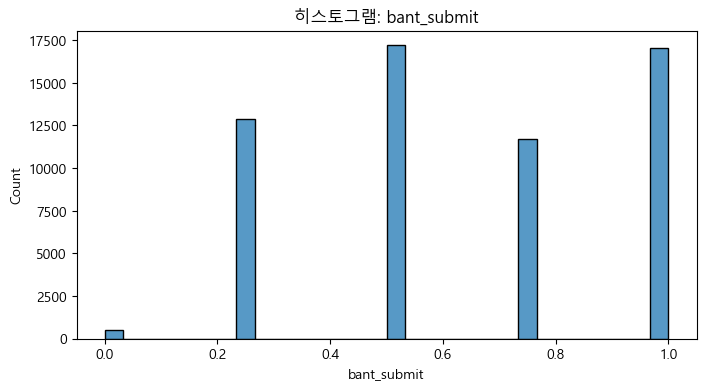

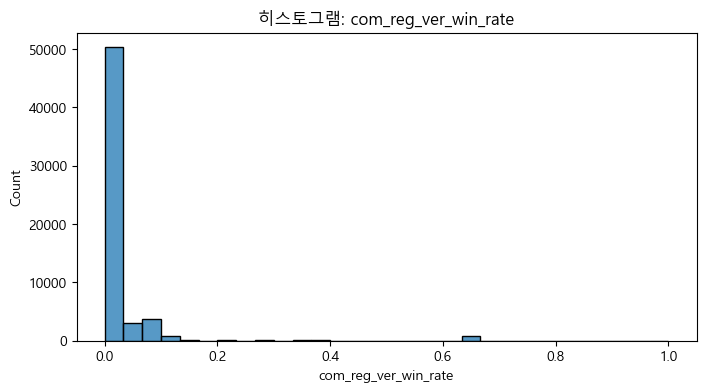

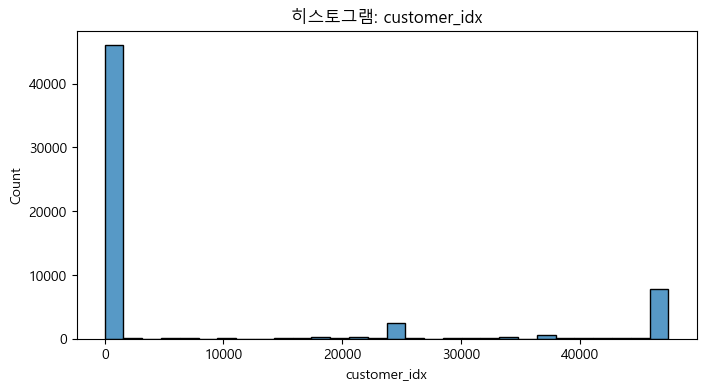

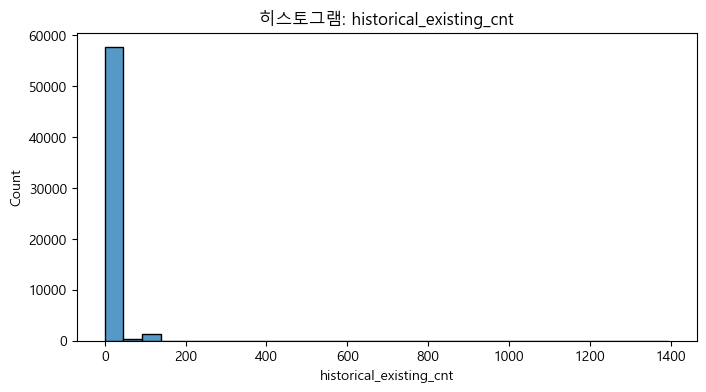

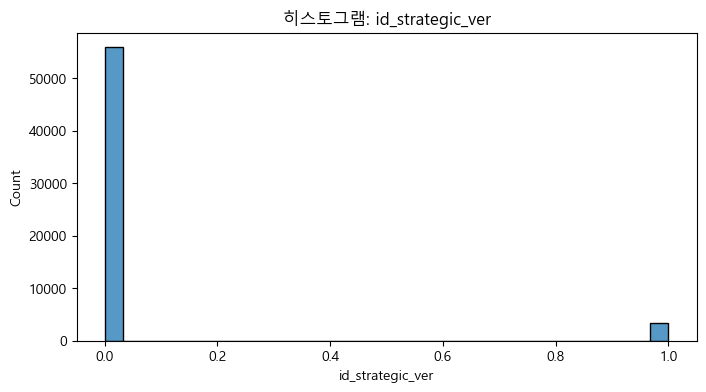

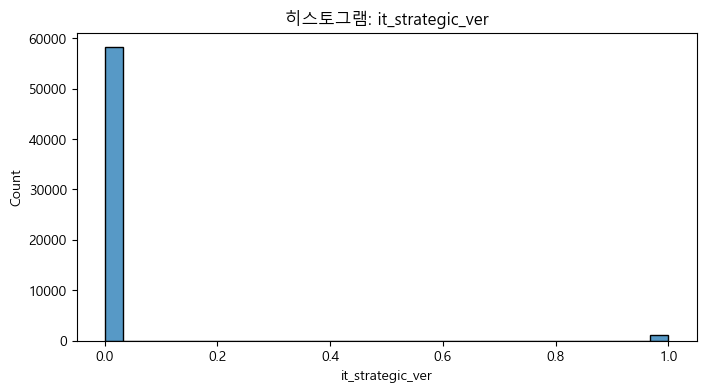

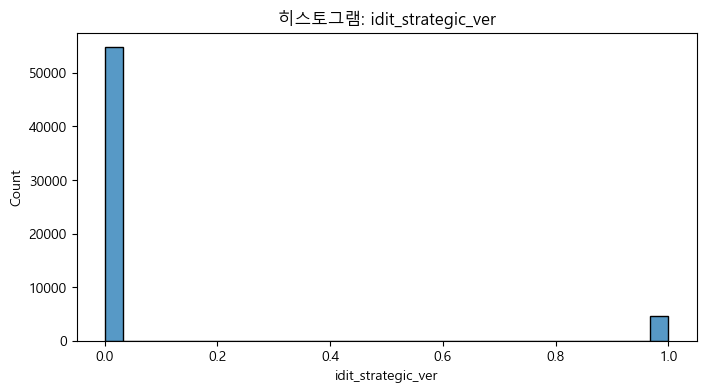

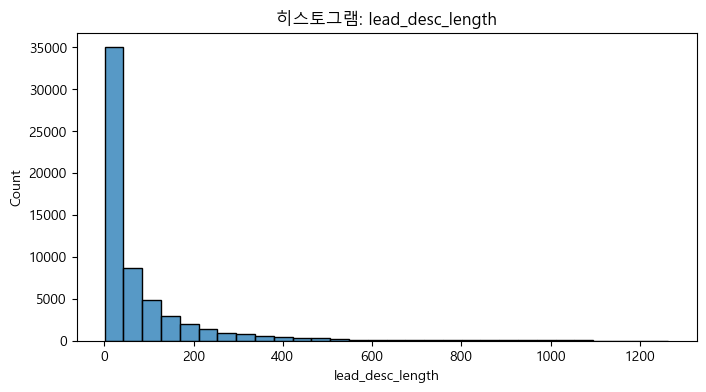

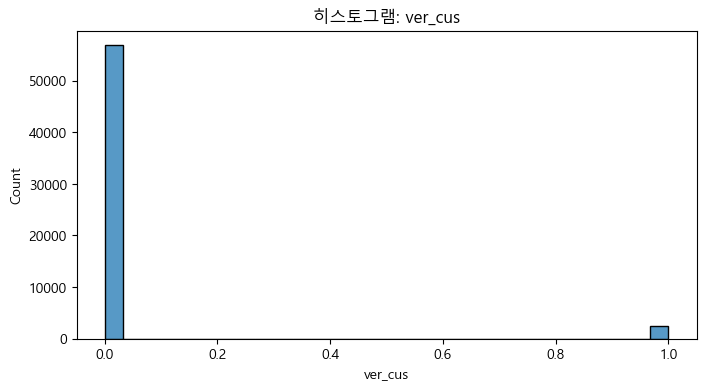

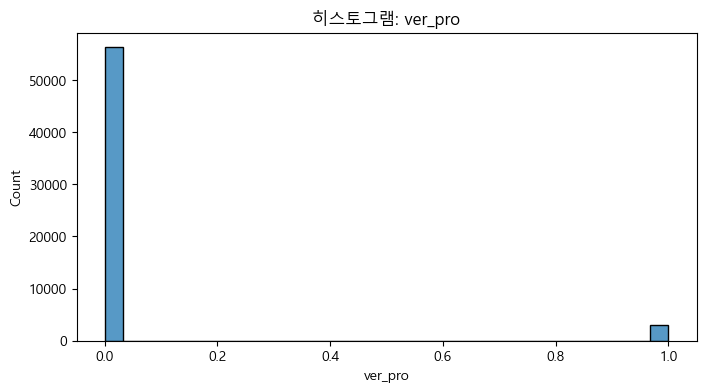

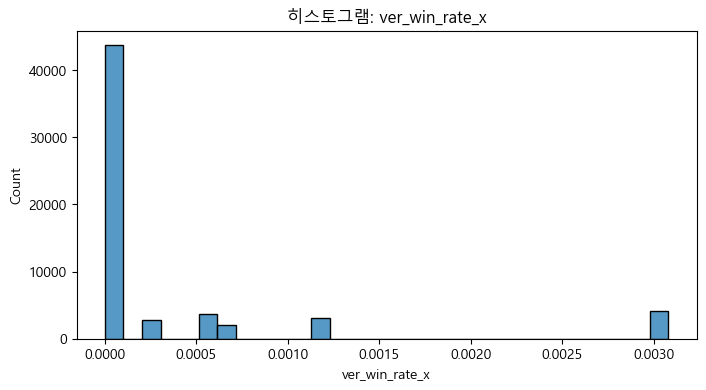

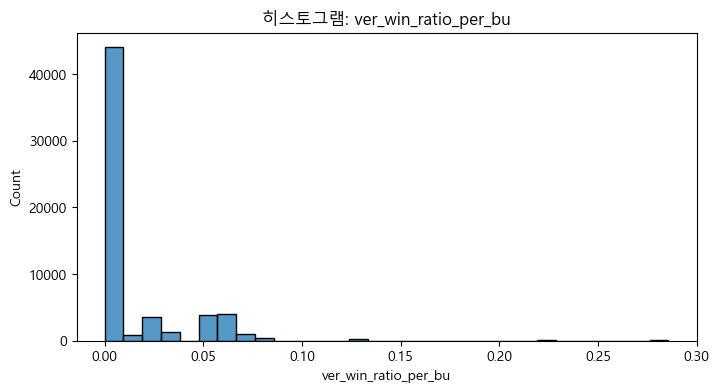

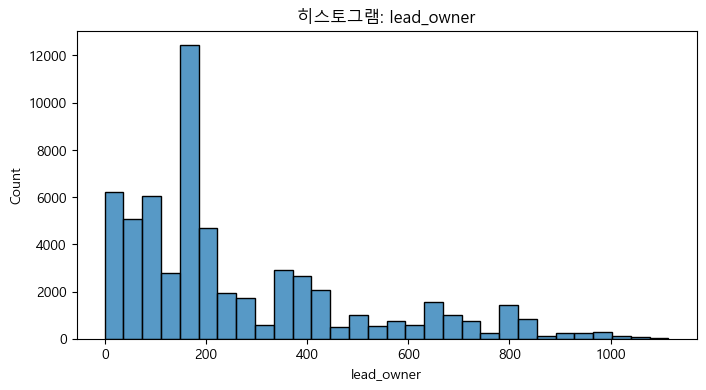

In [19]:
# 각 숫자형 컬럼에 대해 히스토그램을 생성합니다.
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[col].dropna(), kde=False, bins=30)  # NaN 값은 제외하고 히스토그램을 그립니다.
    plt.title(f'히스토그램: {col}')
    plt.show()

In [20]:
train['country'] = train['customer_country'].str.split('/').str[-1]
test['country'] = test['customer_country'].str.split('/').str[-1]

In [21]:
train['country'] = train['country'].str.strip()
test['country'] = test['country'].str.strip()

In [22]:
country_mapping = {
    'u.a.e': 'united arab emirates',
    'uae dubai': 'united arab emirates',
    ' india': 'india',
    'türkiye': 'turkey',
    'us': 'united states',
    'usa': 'united states',
    ' united states' : 'united states',
    'u.k': 'united kingdom',
    'uk': 'united kingdom',
    'brasil': 'brazil',
    'ha noi': 'vietnam',
    'south korea': 'korea',
    'republic of korea': 'korea',
    's. korea': 'korea',
    'czech': 'czech republic',
    'czechia': 'czech republic',
    'macau': 'china',
    'england': 'united kingdom',
    'scotland': 'united kingdom',
    'prc': 'china',
    'mainland china': 'china',
    'france': 'france',
    'french': 'france',
    'paris': 'france',  # 특정 도시를 나라명으로 매핑
    'germany': 'germany',
    'deutschland': 'germany',  # 독일의 독일어 명칭
    'berlin': 'germany',  # 특정 도시를 나라명으로 매핑
    'abu dhabi': 'united arab emirates',  # 특정 도시를 나라명으로 매핑
    'dubai': 'united arab emirates',  # 특정 도시를 나라명으로 매핑
}

# 나라명 표준화 적용
train['country'] = train['country'].replace(country_mapping)
test['country'] = test['country'].replace(country_mapping)

In [23]:
frequency = train['country'].value_counts()
idx_to_replace = frequency[frequency <= 3].index
train['country'] = train['country'].replace(idx_to_replace, 'other')

frequency = test['country'].value_counts()
idx_to_replace = frequency[frequency <= 3].index
test['country'] = test['country'].replace(idx_to_replace, 'other')

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         59299 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     59299 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            59299 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  59299 non-null  float64
 8   id_strategic_ver         59299 non-null  float64
 9   it_strategic_ver         59299 non-null  float64
 10  idit_strategic_ver       59299 non-null  float64
 11  customer_job             59299 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             59299 non-null  object 
 14  product_category      

In [25]:
train['customer_idx'].value_counts()

customer_idx
-1        45931
 47466     7686
 25096     2421
 37680      367
 18030      331
          ...  
 43541       11
 23100       11
 29278       11
 4833        11
 38513       11
Name: count, Length: 100, dtype: int64

In [33]:
# import pandas as pd
# import matplotlib.pyplot as plt
# 
# # 가정: 'train' 데이터프레임은 이미 존재하고, 'country'와 'is_converted' 컬럼을 포함하고 있다.
# 
# # 각 국가별로 True와 False의 개수를 집계합니다.
# conversion_counts = train.groupby(['country', 'is_converted']).size().unstack(fill_value=0)
# 
# # True 비율을 계산합니다.
# conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)
# 
# # True 비율이 높은 상위 10개 국가를 선택합니다.
# top_countries = conversion_rates[True].sort_values(ascending=False).head(10).index
# 
# # 상위 10개 국가의 데이터를 선택합니다.
# top_conversion_rates = conversion_rates.loc[top_countries]
# 
# # 시각화: 상위 10개 국가의 전환율을 바 차트로 시각화합니다.
# top_conversion_rates.plot(kind='bar', stacked=True, figsize=(10, 6))
# 
# # 그래프 제목과 레이블 설정
# plt.title('Top 10 Countries Conversion Rate')
# plt.xlabel('Country')
# plt.ylabel('Conversion Rate')
# 
# # x축 레이블 회전
# plt.xticks(rotation=45)
# 
# # 범례 설정
# plt.legend(title='Is Converted', labels=['False', 'True'])
# 
# # 그래프 표시
# plt.tight_layout()
# plt.show()

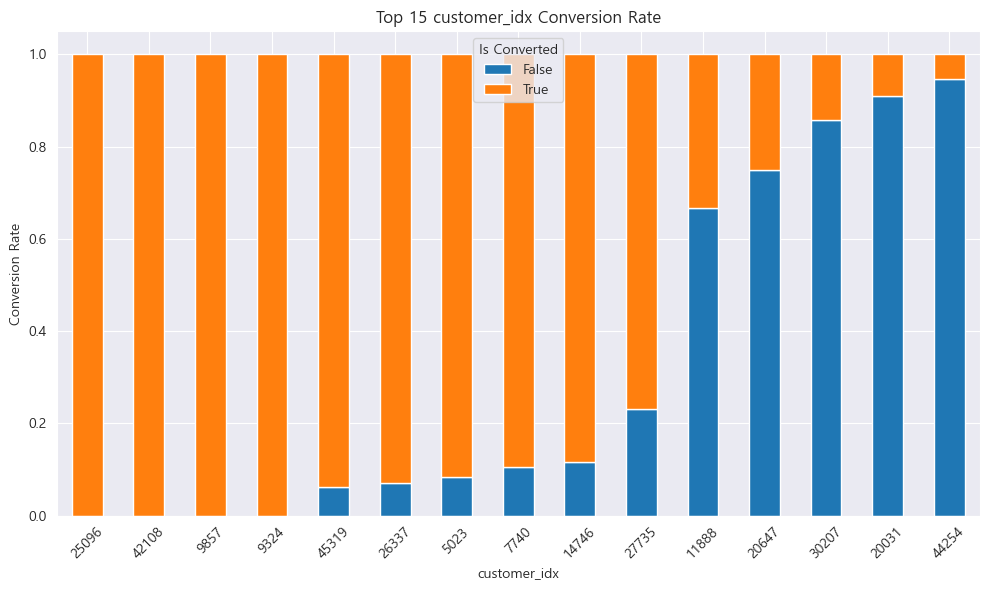

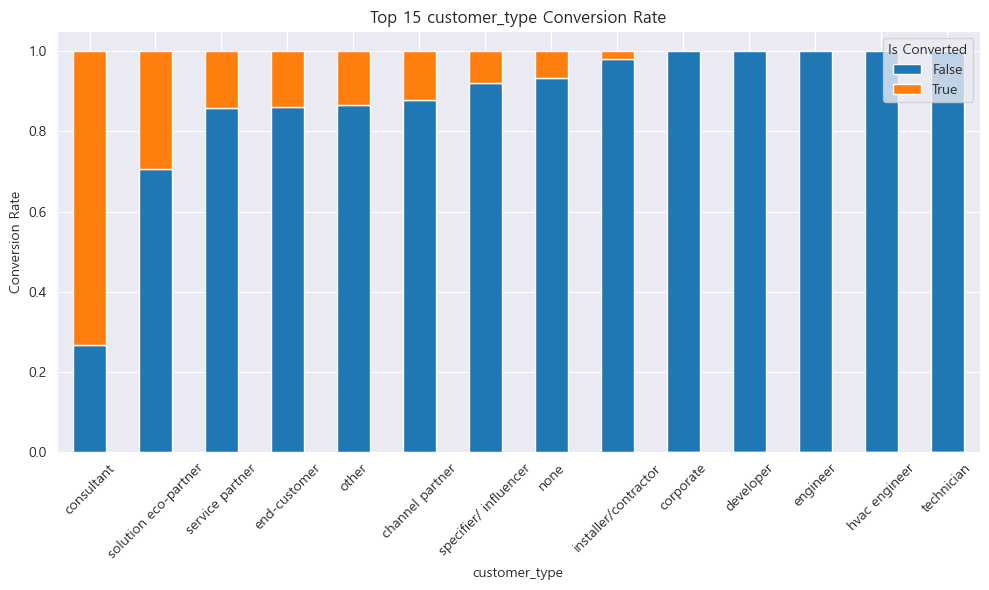

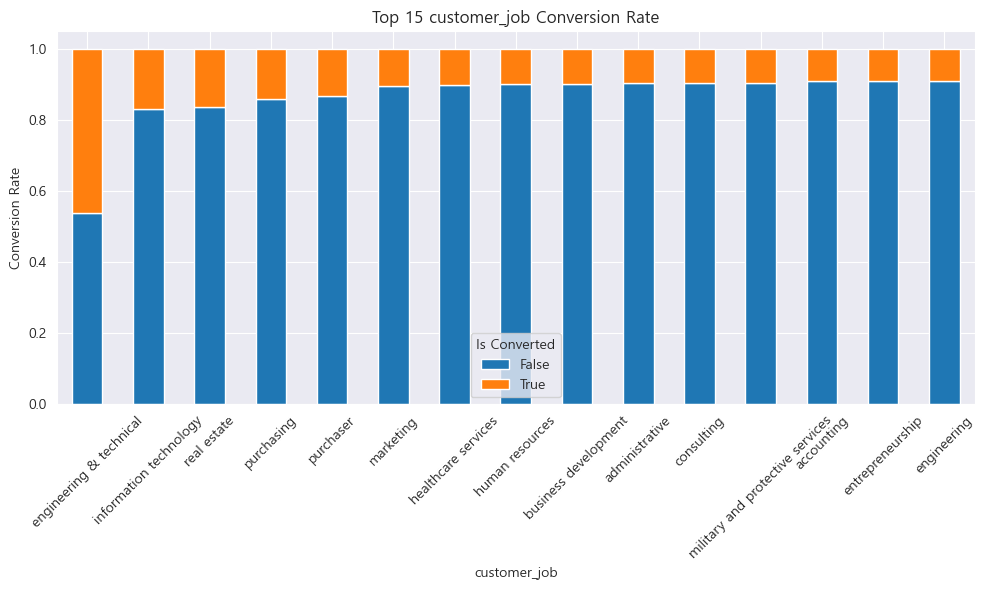

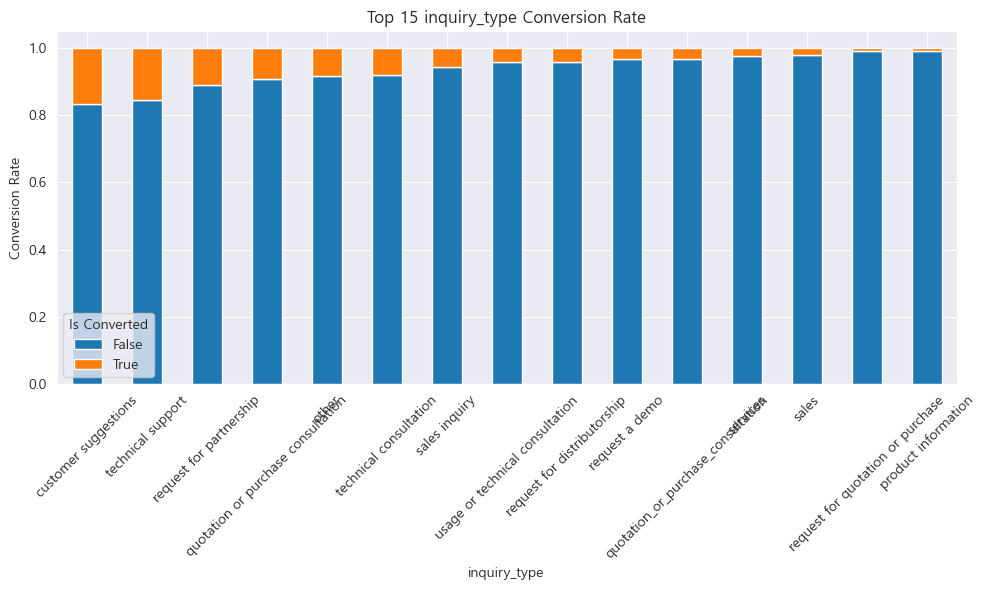

C:\Users\SJ\AppData\Local\Temp\ipykernel_4552\4097968488.py:29: UserWarning: Glyph 23631 (\N{CJK UNIFIED IDEOGRAPH-5C4F}) missing from current font.
  plt.tight_layout()
C:\Users\SJ\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23631 (\N{CJK UNIFIED IDEOGRAPH-5C4F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


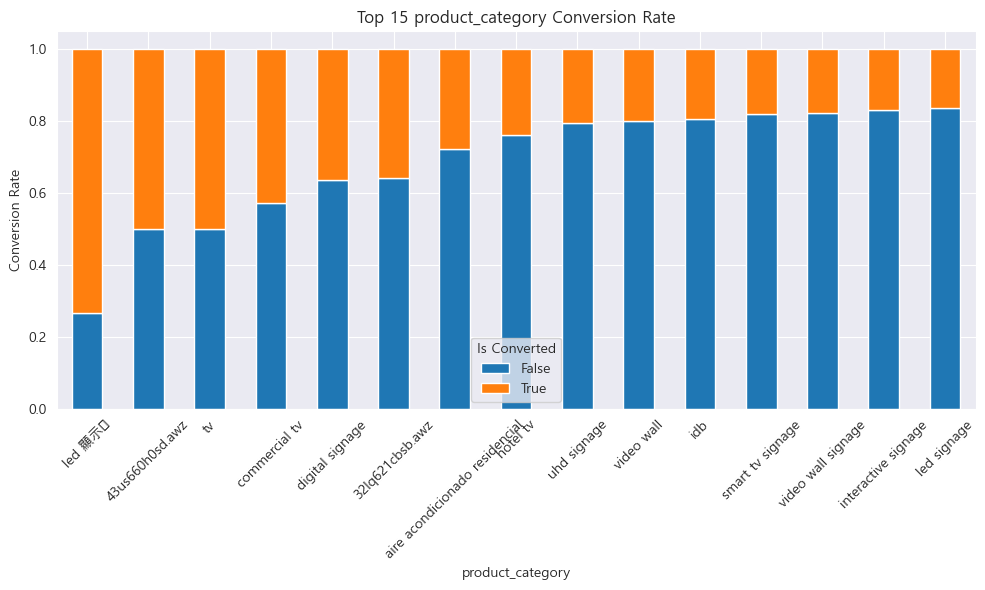

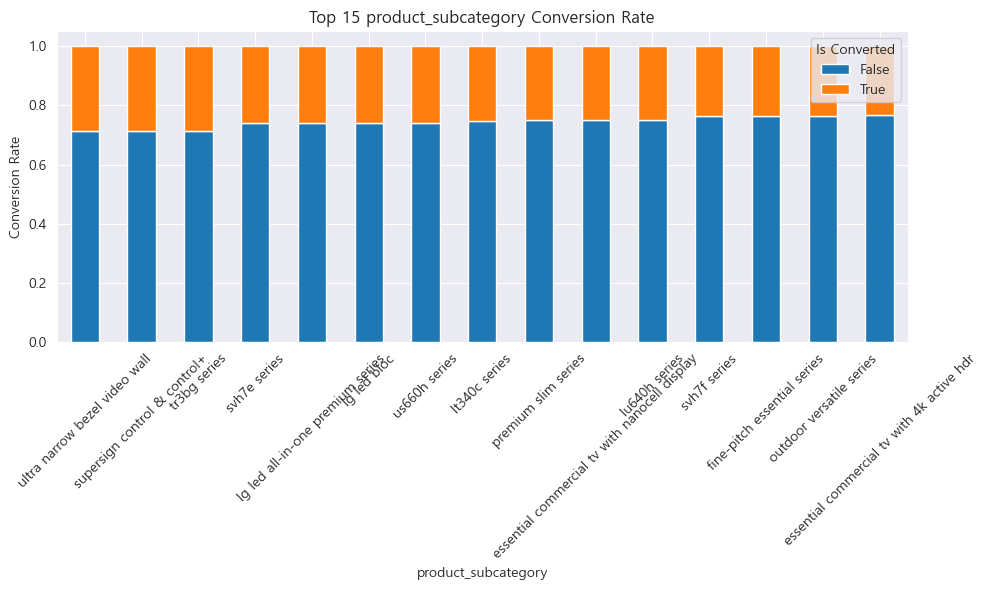

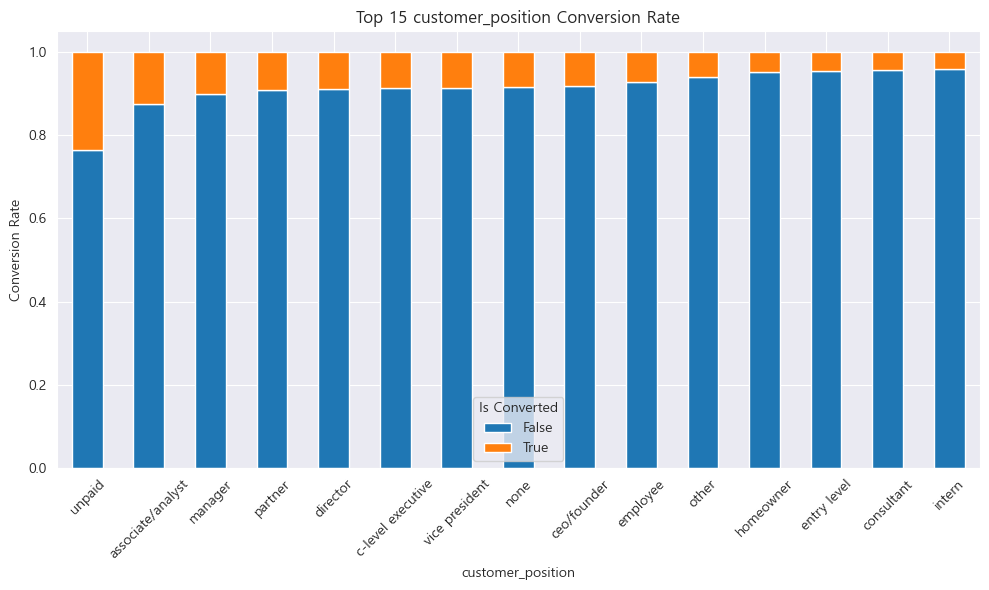

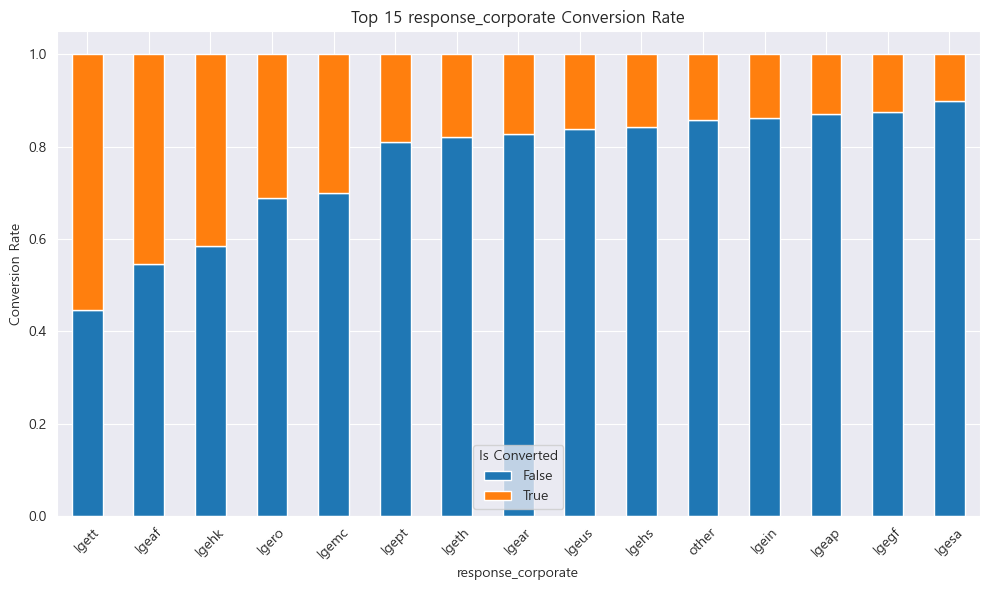

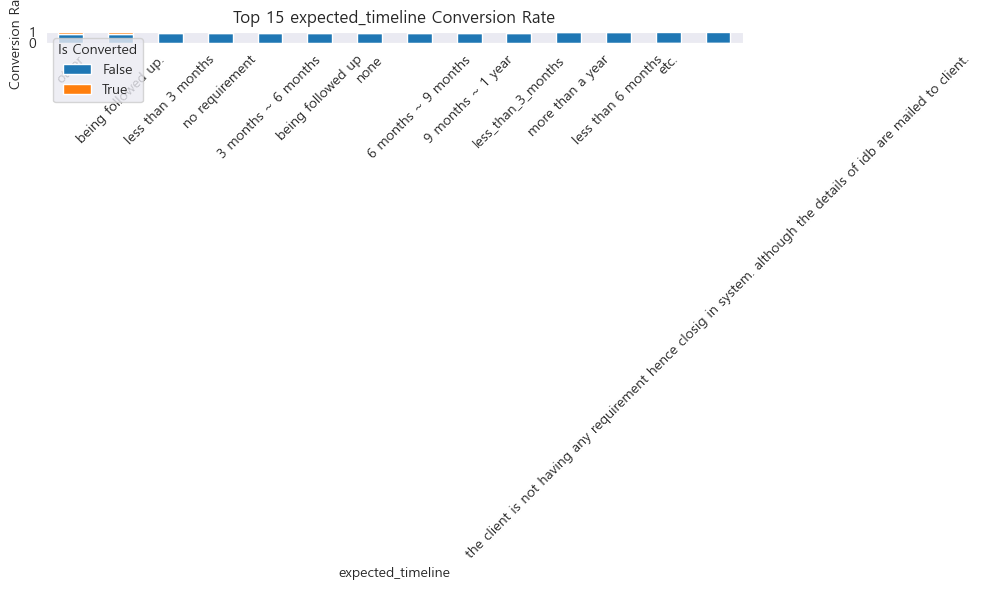

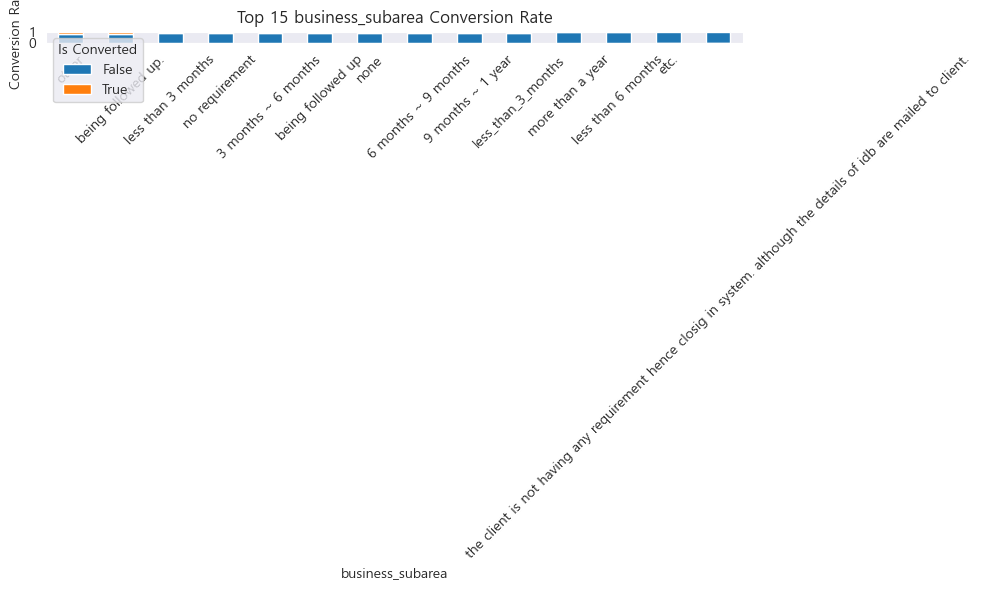

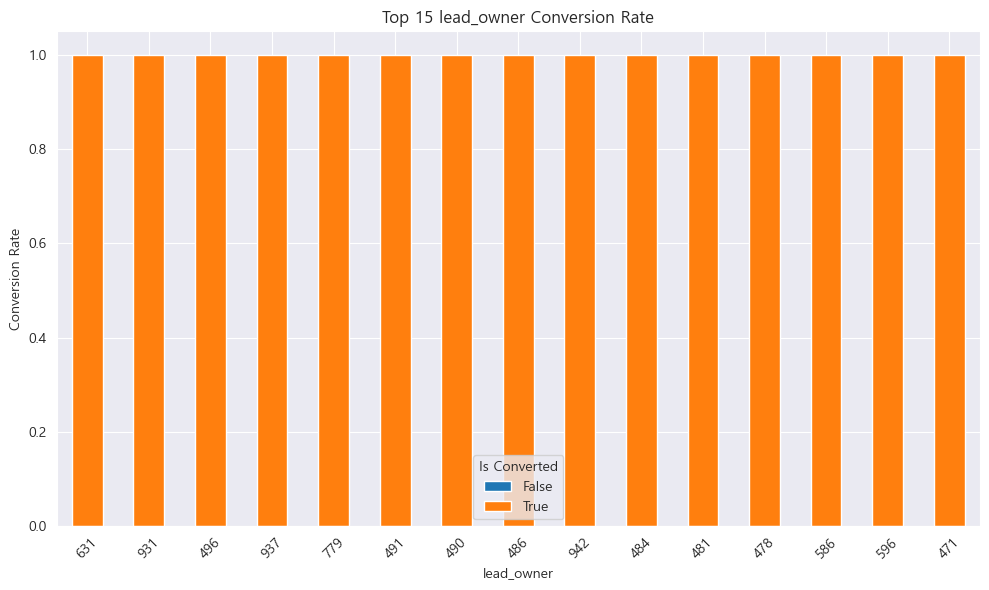

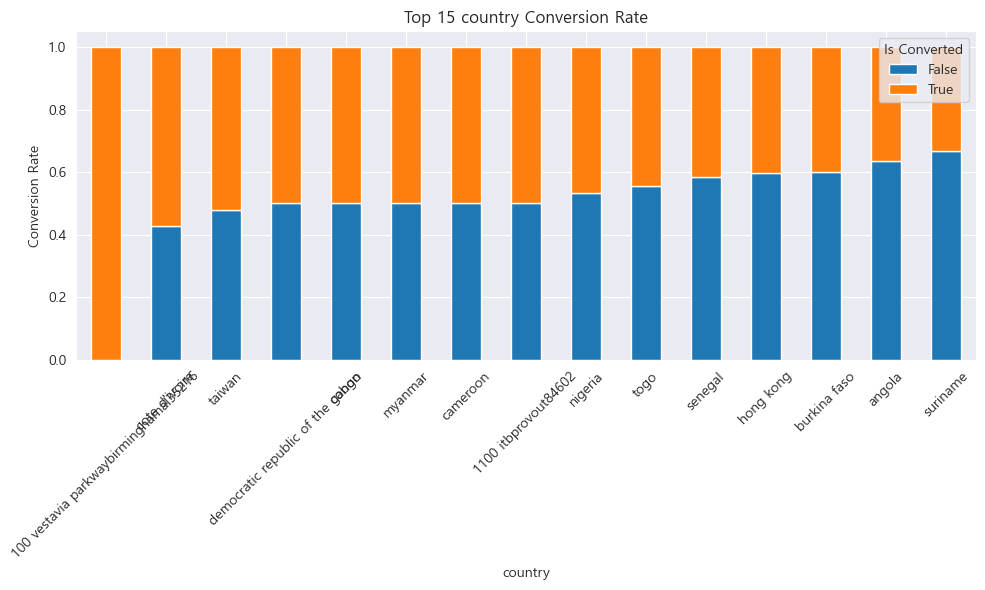

In [35]:
def plot_top_categories_conversion_rate(df, category_col, target_col, top_n=10):
    # 각 범주별로 target_col의 True와 False의 개수를 집계합니다.
    conversion_counts = df.groupby([category_col, target_col]).size().unstack(fill_value=0)

    # True 비율을 계산합니다.
    conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)

    # True 비율이 높은 상위 N개 범주를 선택합니다.
    top_categories = conversion_rates[True].sort_values(ascending=False).head(top_n).index

    # 상위 N개 범주의 데이터를 선택합니다.
    top_conversion_rates = conversion_rates.loc[top_categories]

    # 시각화: 상위 N개 범주의 전환율을 바 차트로 시각화합니다.
    ax = top_conversion_rates.plot(kind='bar', stacked=True, figsize=(10, 6))

    # 그래프 제목과 레이블 설정
    plt.title(f'Top {top_n} {category_col} Conversion Rate')
    plt.xlabel(category_col)
    plt.ylabel('Conversion Rate')

    # x축 레이블 회전
    plt.xticks(rotation=45)

    # 범례 설정
    plt.legend(title='Is Converted', labels=['False', 'True'])

    # 그래프 표시
    plt.tight_layout()
    plt.show()

# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['customer_idx', 'customer_type','customer_job', 'inquiry_type','product_category',
           'product_subcategory', 'customer_position','response_corporate',
           'expected_timeline','business_subarea','lead_owner','country']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_top_categories_conversion_rate(train, col, 'is_converted', top_n=15)

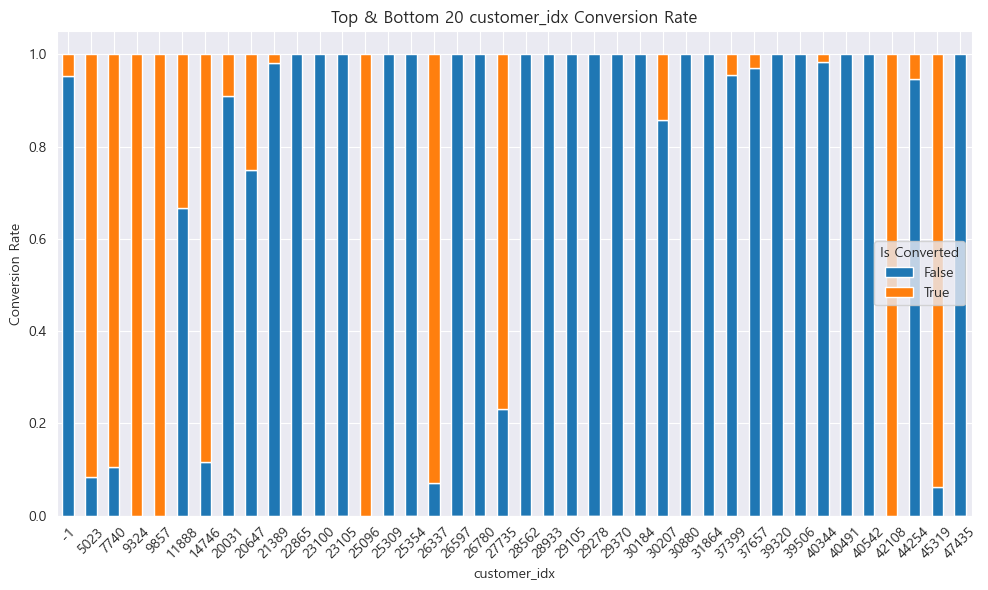

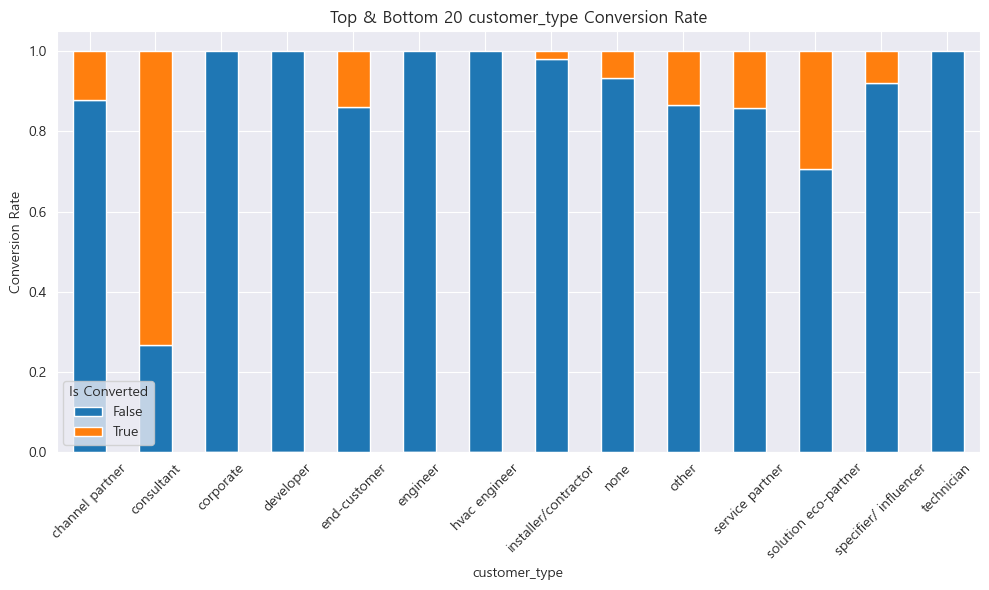

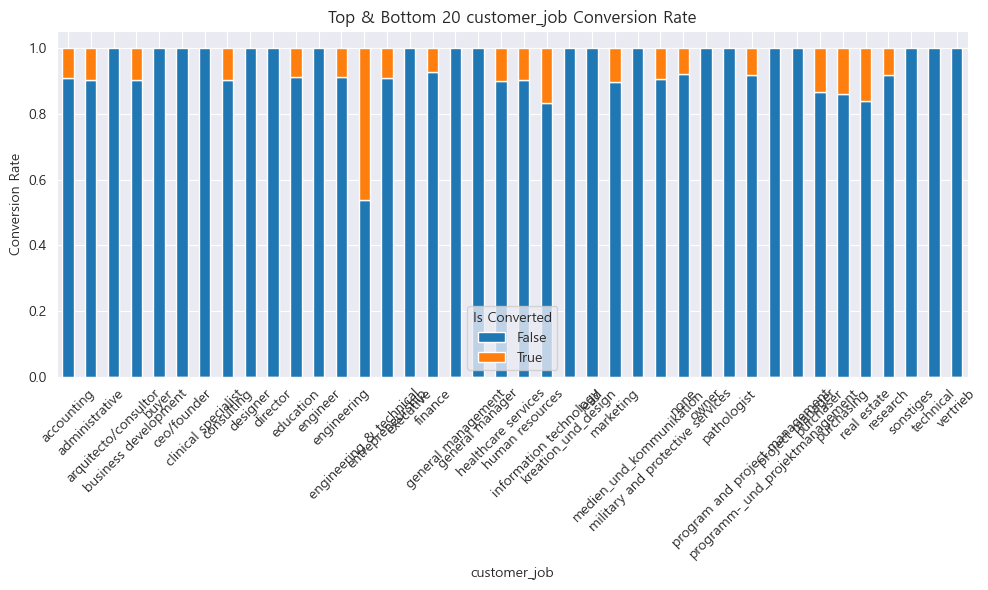

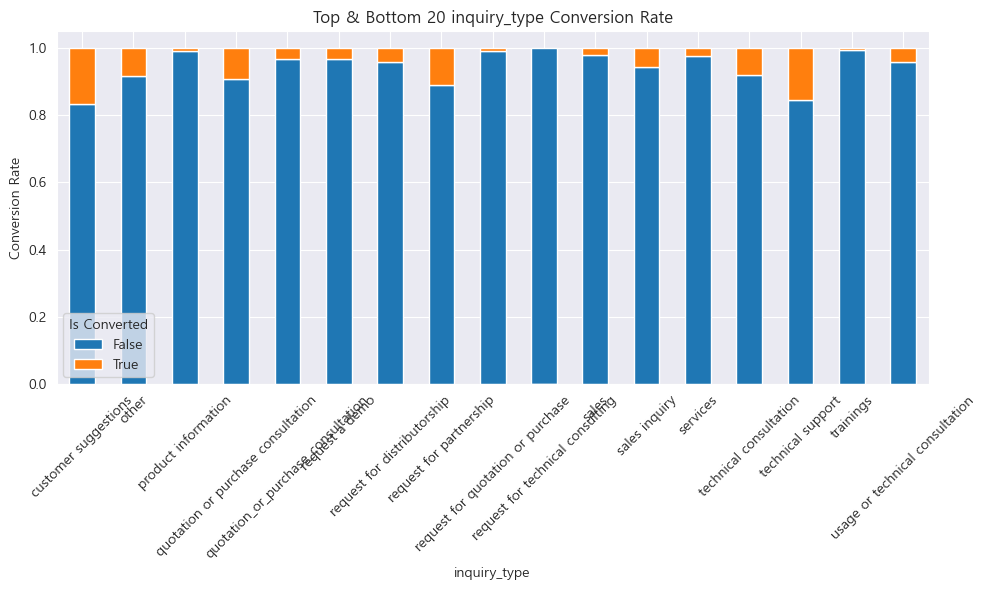

C:\Users\SJ\AppData\Local\Temp\ipykernel_4552\1412641416.py:32: UserWarning: Glyph 23631 (\N{CJK UNIFIED IDEOGRAPH-5C4F}) missing from current font.
  plt.tight_layout()
C:\Users\SJ\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23631 (\N{CJK UNIFIED IDEOGRAPH-5C4F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


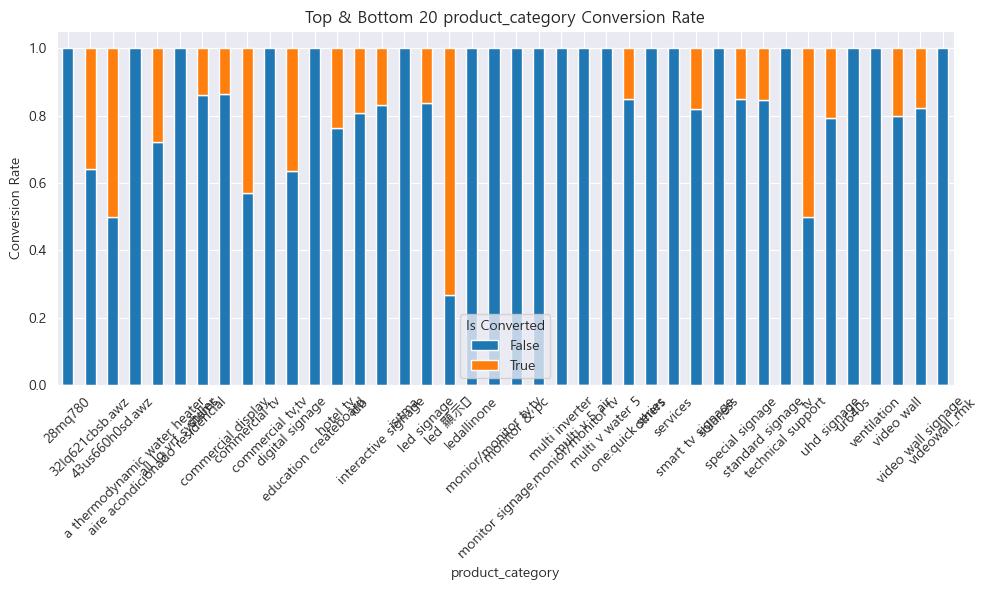

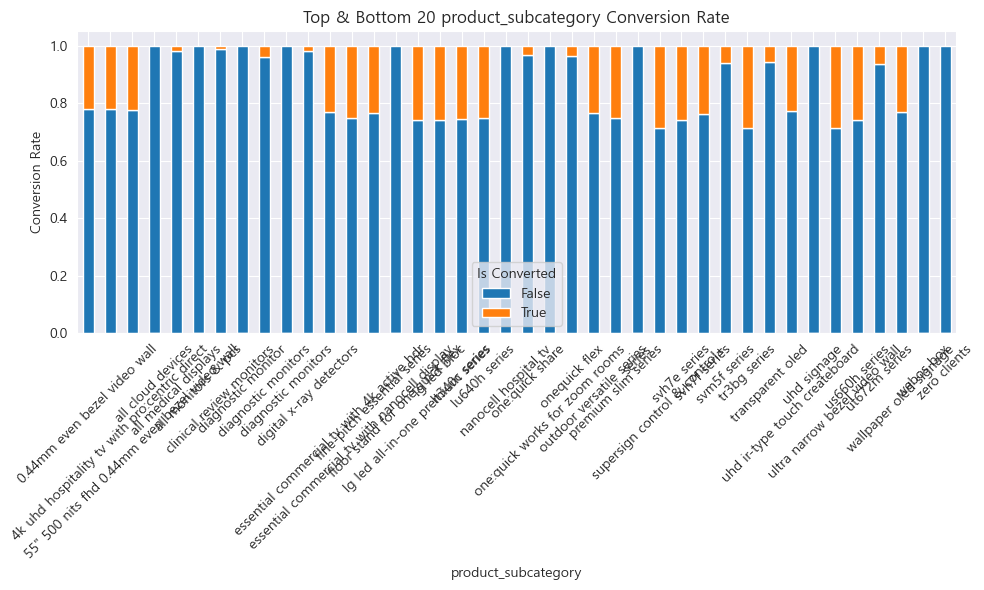

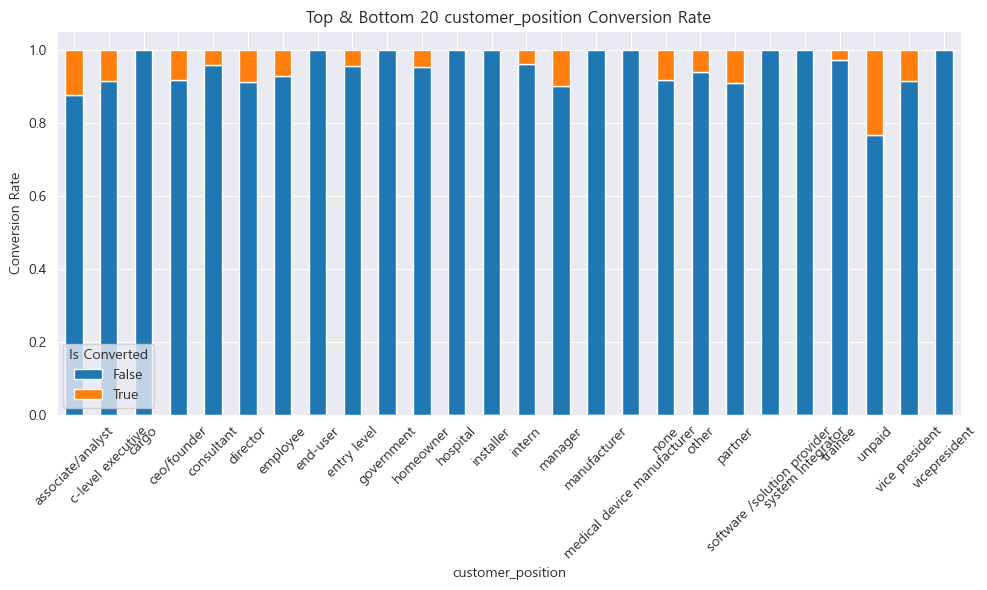

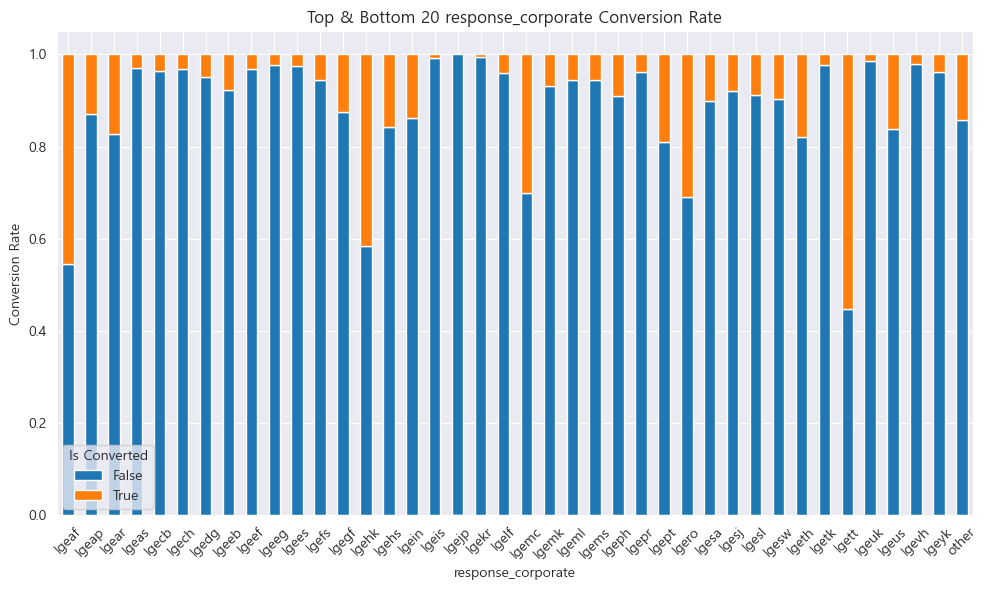

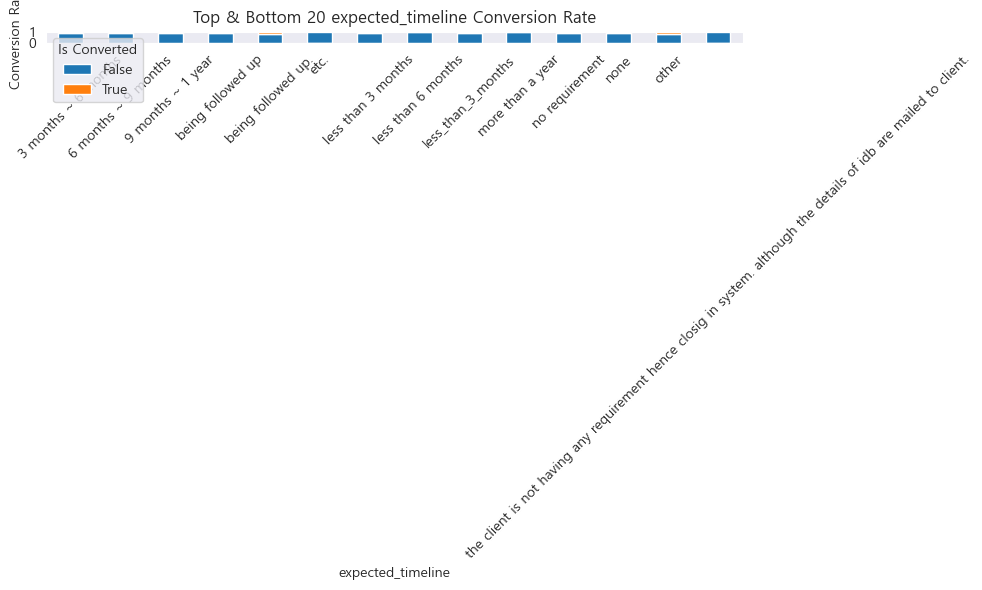

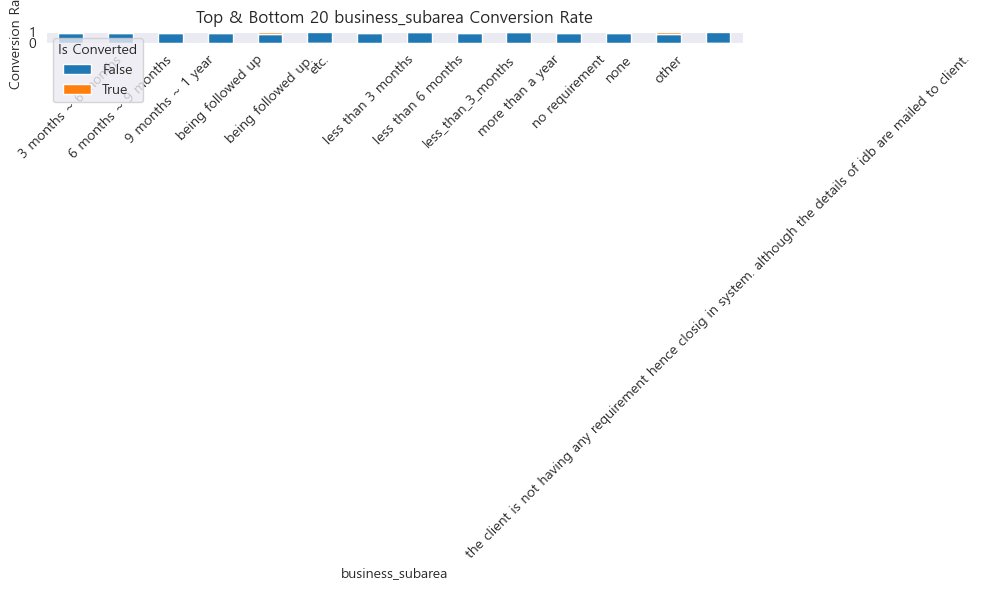

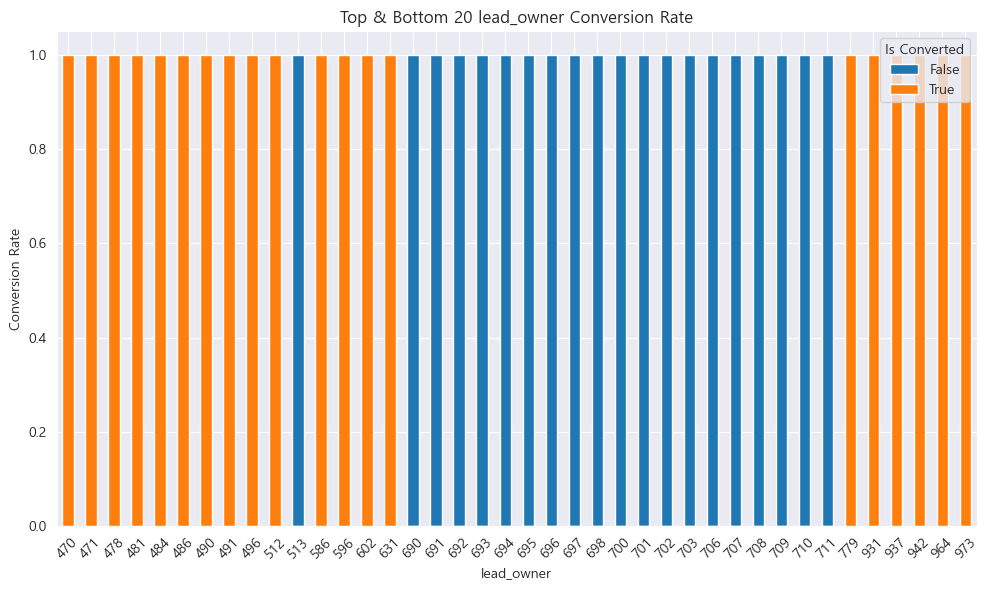

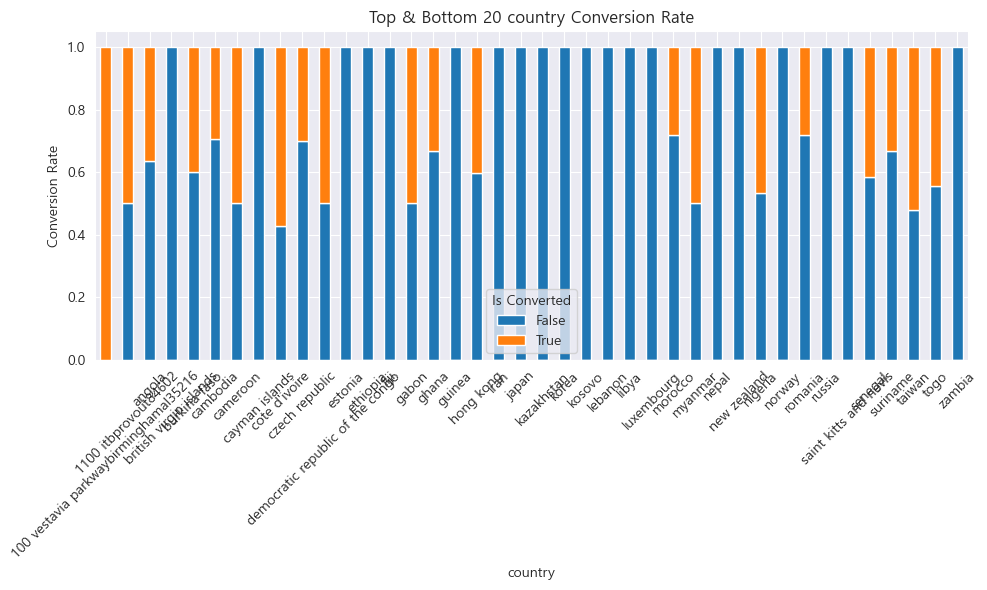

In [36]:
def plot_categories_conversion_rate(df, category_col, target_col, top_n=10):
    # 각 범주별로 target_col의 True와 False의 개수를 집계합니다.
    conversion_counts = df.groupby([category_col, target_col]).size().unstack(fill_value=0)

    # True 비율을 계산합니다.
    conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)

    # True 비율이 높은 상위 N개 범주를 선택합니다.
    top_categories = conversion_rates[True].sort_values(ascending=False).head(top_n).index

    # True 비율이 낮은 하위 N개 범주를 선택합니다.
    bottom_categories = conversion_rates[True].sort_values(ascending=True).head(top_n).index

    # 상위 N개 및 하위 N개 범주의 데이터를 선택합니다.
    top_bottom_conversion_rates = conversion_rates.loc[top_categories.union(bottom_categories)]

    # 시각화: 상위 N개 및 하위 N개 범주의 전환율을 바 차트로 시각화합니다.
    ax = top_bottom_conversion_rates.plot(kind='bar', stacked=True, figsize=(10, 6))

    # 그래프 제목과 레이블 설정
    plt.title(f'Top & Bottom {top_n} {category_col} Conversion Rate')
    plt.xlabel(category_col)
    plt.ylabel('Conversion Rate')

    # x축 레이블 회전
    plt.xticks(rotation=45)

    # 범례 설정
    plt.legend(title='Is Converted', labels=['False', 'True'])

    # 그래프 표시
    plt.tight_layout()
    plt.show()

# train 데이터프레임과 is_converted 컬럼을 가정하고 있음
obj_col = ['customer_idx', 'customer_type','customer_job', 'inquiry_type','product_category',
           'product_subcategory', 'customer_position','response_corporate',
           'expected_timeline','business_subarea','lead_owner','country']

# 각 범주형 컬럼에 대해 시각화 함수 실행
for col in obj_col:
    plot_categories_conversion_rate(train, col, 'is_converted', top_n=20)

In [27]:
# 'lead_owner' 카테고리별로 'is_converted'의 평균과 갯수를 계산합니다.
conversion_rate_and_count_by_lead_owner = train.groupby('lead_owner')['is_converted'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

# 결과를 출력합니다.
conversion_rate_and_count_by_lead_owner

,mean,count
lead_owner,,
631,1.0,1
931,1.0,2
496,1.0,1
937,1.0,2
779,1.0,1
...,...,...
198,0.0,50
665,0.0,1
664,0.0,2


In [38]:
train[train['lead_owner'] == 342]

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,country
2874,0.75,//brazil,id,0.000000,-1,none,enterprise,0.0,0.0,0.0,...,none,0,0,0.000000,0.000000,none,none,342,False,brazil
10598,0.25,//brazil,id,0.000000,-1,none,enterprise,0.0,0.0,0.0,...,none,0,0,0.000000,0.000000,none,none,342,False,brazil
10602,0.50,//brazil,id,0.000000,-1,none,enterprise,0.0,0.0,0.0,...,none,0,0,0.000000,0.000000,none,none,342,False,brazil
22010,0.75,/santos/brazil,id,0.080692,-1,none,enterprise,0.0,0.0,0.0,...,less than 3 months,0,0,0.000543,0.064070,special purpose,less than 3 months,342,False,brazil
22844,1.00,/guarulhos/brazil,id,0.032787,-1,none,smb,0.0,0.0,0.0,...,3 months ~ 6 months,0,0,0.000572,0.048630,education,3 months ~ 6 months,342,False,brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59125,1.00,/belo horizonte/brazil,id,0.042254,-1,end-customer,enterprise,0.0,0.0,0.0,...,less than 3 months,0,0,0.000026,0.031579,public facility,less than 3 months,342,False,brazil
59127,1.00,/belo horizonte/brazil,id,0.042254,-1,end-customer,enterprise,0.0,0.0,0.0,...,less than 3 months,0,0,0.000026,0.031579,public facility,less than 3 months,342,False,brazil
59142,1.00,/manaus/brazil,id,0.042254,-1,end-customer,smb,0.0,0.0,0.0,...,less than 3 months,0,0,0.000026,0.031579,public facility,less than 3 months,342,True,brazil
59151,1.00,/recife/brazil,id,0.042254,-1,end-customer,smb,3.0,0.0,0.0,...,less than 3 months,0,0,0.000026,0.031579,public facility,less than 3 months,342,False,brazil


In [28]:
conversion_dict = conversion_rate_and_count_by_lead_owner['mean'].to_dict()

# 이제 'train' 데이터 프레임에 새로운 열 'mean_value'를 추가하고, 'conversion_dict'를 사용하여 값을 매핑합니다.
train['lead_owner_mean_value'] = train['lead_owner'].map(conversion_dict)
test['lead_owner_mean_value'] = test['lead_owner'].map(conversion_dict)

In [29]:
# 조건에 따라 새로운 컬럼을 만들기 위한 기준을 설정합니다.
conditions = [
    ('new_column_90', (conversion_rate_and_count_by_lead_owner['mean'] >= 0.99) & (conversion_rate_and_count_by_lead_owner['count'] >= 5)),
    ('new_column_80', (conversion_rate_and_count_by_lead_owner['mean'] < 0.99) & (conversion_rate_and_count_by_lead_owner['mean'] >= 0.8) & (conversion_rate_and_count_by_lead_owner['count'] >= 5)),
    ('new_column_50', (conversion_rate_and_count_by_lead_owner['mean'] < 0.8) & (conversion_rate_and_count_by_lead_owner['mean'] >= 0.5) & (conversion_rate_and_count_by_lead_owner['count'] >= 5)),
    ('new_column_20', (conversion_rate_and_count_by_lead_owner['mean'] < 0.5) & (conversion_rate_and_count_by_lead_owner['mean'] >= 0.2) & (conversion_rate_and_count_by_lead_owner['count'] >= 5)),
    ('new_column_01', (conversion_rate_and_count_by_lead_owner['mean'] <= 0.01) & (conversion_rate_and_count_by_lead_owner['count'] >= 30))
]

# 각 조건에 따라 새로운 컬럼을 만들고 해당하는 'lead_owner'에 대해 값을 1로 설정합니다.
for col_name, condition in conditions:
    # 조건을 만족하는 'lead_owner'를 찾습니다.
    qualified_lead_owners = conversion_rate_and_count_by_lead_owner[condition].index

    # 새로운 컬럼을 생성하고 기본값을 0으로 설정합니다.
    train[col_name] = 0
    test[col_name] = 0 
    
    # 조건을 만족하는 'lead_owner'의 행에 대해서만 새로운 컬럼의 값을 1로 설정합니다.
    train.loc[train['lead_owner'].isin(qualified_lead_owners), col_name] = 1
    test.loc[train['lead_owner'].isin(qualified_lead_owners), col_name] = 1

# train.drop('lead_owner', axis = 1 , inplace = True)
# test.drop('lead_owner', axis = 1 , inplace = True)

In [30]:
# 'response_corporate' 컬럼을 생성하고 기본값을 0으로 설정합니다.
train['response_corporate_high'] = 0
test['response_corporate_high'] = 0

train['response_corporate_low'] = 0
test['response_corporate_low'] = 0
# 'lead_owner' 값이 'lgett', 'lgeaf', 'lgehk' 중 하나인 행에 대해서 'response_corporate' 값을 1로 설정합니다.
train.loc[train['response_corporate'].isin(['lgett', 'lgeaf', 'lgehk']), 'response_corporate_high'] = 1
test.loc[test['response_corporate'].isin(['lgett', 'lgeaf', 'lgehk']), 'response_corporate_high'] = 1

# 'lead_owner' 값이 'lgett', 'lgeaf', 'lgehk' 중 하나인 행에 대해서 'response_corporate' 값을 1로 설정합니다.
train.loc[train['response_corporate'].isin(['lgeis', 'lgejp', 'lgekr','lgeuk']), 'response_corporate_low'] = 1
test.loc[test['response_corporate'].isin(['lgeis', 'lgejp', 'lgekr','lgeuk']), 'response_corporate_low'] = 1

# train.drop('response_corporate', axis = 1 , inplace = True)
# test.drop('response_corporate', axis = 1 , inplace = True)

In [31]:
# 'response_corporate' 컬럼을 생성하고 기본값을 0으로 설정합니다.
train['country_2'] = 0
test['country_2'] = 0


train.loc[train['country'].isin(['brazil','colombia','india','philippines','united kingdom']), 'country_2'] = 1
test.loc[test['country'].isin(['brazil','colombia','india','philippines','united kingdom']), 'country_2'] = 1

# train.drop('country', axis = 1 , inplace = True)
# test.drop('country', axis = 1 , inplace = True)

In [32]:
# 'response_corporate' 컬럼을 생성하고 기본값을 0으로 설정합니다.
train['customer_idx_row'] = 0
test['customer_idx_row'] = 0

train.loc[train['customer_idx'].isin([
    47466, 37680, 21321, 4936, 32240, 25309, 19804, 40491,
    42067, 37657, 31864, 33773, 37399, 40344, 7195, 18030,
    33334, 7810, 33350, 16590, 742, 9624
]), 'customer_idx_row'] = 1
test.loc[test['customer_idx'].isin([
    47466, 37680, 21321, 4936, 32240, 25309, 19804, 40491,
    42067, 37657, 31864, 33773, 37399, 40344, 7195, 18030,
    33334, 7810, 33350, 16590, 742, 9624
]), 'customer_idx_row'] = 1

# train.drop('customer_idx', axis = 1 , inplace = True)
# test.drop('customer_idx', axis = 1 , inplace = True)

In [34]:
train['ver_win_rate_x_category'] = train['ver_win_rate_x'].astype('object')
test['ver_win_rate_x_category'] = test['ver_win_rate_x'].astype('object')



train['historical_existing_cnt_category'] = train['historical_existing_cnt']
test['historical_existing_cnt_category'] = test['historical_existing_cnt']

frequency = train['historical_existing_cnt_category'].value_counts()
idx_to_replace = frequency[frequency <= 5].index
train['historical_existing_cnt_category'] = train['historical_existing_cnt_category'].replace(idx_to_replace, 'other')
train['historical_existing_cnt_category'] = train['historical_existing_cnt_category'].astype('object')


train_unique_values = {
    'historical_existing_cnt_category': set(train[train['historical_existing_cnt_category'] != 'other']['historical_existing_cnt_category'])
}


for col, unique_values in train_unique_values.items():
    test[col] = test[col].apply(lambda x: x if x in unique_values else 'other')


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   bant_submit                       59299 non-null  float64
 1   customer_country                  59299 non-null  object 
 2   business_unit                     59299 non-null  object 
 3   com_reg_ver_win_rate              59299 non-null  float64
 4   customer_idx                      59299 non-null  int64  
 5   customer_type                     59299 non-null  object 
 6   enterprise                        59299 non-null  object 
 7   historical_existing_cnt           59299 non-null  float64
 8   id_strategic_ver                  59299 non-null  float64
 9   it_strategic_ver                  59299 non-null  float64
 10  idit_strategic_ver                59299 non-null  float64
 11  customer_job                      59299 non-null  object 
 12  lead

In [38]:
train.to_csv('../Database/train_test_newcol7.csv', index=False)
test.to_csv('../Database/test_test_newcol7.csv', index=False)